# Import THe Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set() #sets the theme
from pandas_datareader import data as pdr
import random
import yfinance as yf
from collections import deque
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


## Get the data

In [36]:
yf.pdr_override()
df_complete = pdr.get_data_yahoo("TCS.NS",start = '2018-01-01').reset_index()
df_complete.to_csv("TCS.NS",index = False)
df_complete

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,1341.150024,1347.400024,1317.500000,1322.800049,1229.915527,1351760
1,2018-01-02,1330.000000,1334.800049,1310.099976,1315.599976,1223.221069,1920290
2,2018-01-03,1316.000000,1334.500000,1315.599976,1319.324951,1226.684326,1257120
3,2018-01-04,1325.000000,1331.000000,1320.000000,1328.550049,1235.261597,913082
4,2018-01-05,1325.000000,1349.750000,1325.000000,1344.599976,1250.184570,1153706
...,...,...,...,...,...,...,...
837,2021-05-31,3150.000000,3170.350098,3128.600098,3159.149902,3159.149902,1652799
838,2021-06-01,3168.600098,3169.949951,3132.000000,3153.000000,3153.000000,1377441
839,2021-06-02,3150.850098,3159.449951,3115.000000,3129.449951,3129.449951,2240078
840,2021-06-03,3154.550049,3154.550049,3122.649902,3141.250000,3141.250000,1281706


## Defining the q-lerning agent

`state_size,window_size,batch_size and deque`
`Two models target and main model are used`

In [37]:
df = df_complete.copy()

name = 'Trading-bot'


class Bot:
    
    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256 #output size
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self,state_size,window_size,trend,skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size//2
        self.trend = trend #bought stock
        self.skip = skip
#         self.action_size = 3 #buy sell or hold
#         self.batch_size = batch_size
#         self.memory = deque(maxlen = 1000)
#         self.inventory = []
#         self.gamma = 0.95
#         self.epsilon = 0.5
#         self.epsilon_min = 0.01
#         self.epsilon_decay = 0.999
#         tf.reset_default_graph() #Clears the default graph stack and resets the global default graph.
#         self.sess = tf.InteractiveSession()
        
        self.X = tf.placeholder(tf.float32,[None,self.state_size])
        self.REWARDS = tf.placeholder(tf.float32,(None))
        self.ACTIONS = tf.placeholder(tf.int32,(None))
        feed_forward = tf.layers.dense(inputs = self.X, units = self.LAYER_SIZE,activation = tf.nn.relu)
        self.logits = tf.layers.dense(inputs = feed_forward, units = self.OUTPUT_SIZE,activation = tf.nn.softmax)
        
        input_y = tf.one_hot(indices = self.ACTIONS, depth=self.OUTPUT_SIZE)
        
        #Example of one_hot
        # Indices:  tf.Tensor([1 2], shape=(2,), dtype=int32)
        # Res:  tf.Tensor(
        # [[0. 1. 0. 0.]
        #  [0. 0. 1. 0.]], shape=(2, 4), dtype=float32)
        loglike = tf.log((input_y * (input_y - self.logits) + (1-input_y) *(input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS,(-1,1)),[1,self.OUTPUT_SIZE])
        
        self.cost = -tf.reduce_mean(loglike * (rewards + 1))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())  # initialize all global variables 
        
    def predict(self,inputs):
        return self.sess.run(self.logits,feed_dict={self.X:inputs})
    
    
    def get_state(self,t): #t = specific day
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d>=0 else -d *[self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i+1]-block[i])
        return np.array([res])
    
    def discount_rewards(self,r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0,r.size)):
            running_add = running_add * self.GAMMA +r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    
    def get_predicted_action(self,sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    
            
    def buy(self,initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        
        for t in range(0,len(self.trend) -1,self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t <(len(self.trend)-self.half_window):
                inventory.append(self.trend[t])
                initial_money -=self.trend[t]
                states_buy.append(t)
                print(f"day:{t}: buy 1 unit at price: {self.trend[t]},total balance: {initial_money}\n")
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0) #remove first value.
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest=((close[t]-bought_price)/bought_price) * 100
                except:
                    invest = 0
                print(f'day {t},sell 1 unit at price {close[t]},investment {invest},total balance {initial_money}')
                
            state = next_state
            
        invest =((initial_money-starting_money)/starting_money)*100
        total_gains = initial_money - starting_money
        return states_buy,states_sell,total_gains,invest
    
    
    def train(self,iterations,checkpoint,initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            
            for t in range(0,len(self.trend)-1,self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t+1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                    
                    
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                    
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
                
                    
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                self.REWARDS:ep_history[:,2],
                                                self.ACTIONS:ep_history[:,1]})

            if (i+1)% checkpoint == 0:
                print(f"epoch: {i+1} total reward: {total_profit}, cost: {cost}, total money : {starting_money}")

                
            
                
                
                    
                
                
        
        
    

        
        
        
        
        
        
        
        

#### Placeholders
`So far we have used Variables to manage our data, but there is a more basic structure, the placeholder. A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data. In TensorFlowterminology, we then feed data into the graph through these placeholders.`


#### Logits - 
`Logits simply means that the function operates on the unscaled output of earlier layers and that the relative scale to understand the units is linear. It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities (you might have an input of 5).`

#### tf.nn.softmax
`tf.nn.softmax produces just the result of applying the softmax function to an input tensor. The softmax "squishes" the inputs so that sum(input) = 1: it's a way of normalizing. The shape of output of a softmax is the same as the input: it just normalizes the values. The outputs of softmax can be interpreted as probabilities.`

#### tf.tile
` tiling [1, 2, 3, 4] by [3] produces [1, 2, 3, 4,1, 2, 3, 4,1, 2, 3, 4].`

In [38]:
# # importing the library
# import tensorflow as tf
  
# # Initializing the Input
# indices = tf.constant([1, 2])
  
# # Printing the Input
# print("Indices: ", indices)
  
# # Generating one hot Tensor
# res = tf.one_hot(indices, depth = 4)
  
# # Printing the resulting Tensors
# print("Res: ", res )

### Train the agent

In [39]:
close = df.Close.values.tolist()
initial_money = 100000
window_size = 300
skip = 1
# batch_size = 32
agent = Bot(state_size = window_size,window_size=window_size,trend=close,skip=skip)

agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)



C:\Users\Sumit\anaconda3\envs\cv\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\Sumit\anaconda3\envs\cv\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\Sumit\anaconda3\envs\cv\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-37-1edac7a7a8f7>:140: VisibleDeprecatio

epoch: 10 total reward: 54772.648681640625, cost: -7525.82080078125, total money : 90859.69897460938
epoch: 20 total reward: 54974.5224609375, cost: -8804.087890625, total money : 88149.4228515625
epoch: 30 total reward: 61475.57421875, cost: -8742.08203125, total money : 98850.62451171875
epoch: 40 total reward: 55336.697998046875, cost: -9966.0908203125, total money : 90315.04809570312
epoch: 50 total reward: 55471.22302246094, cost: -11051.6337890625, total money : 88154.2734375
epoch: 60 total reward: 54940.498291015625, cost: -11601.2861328125, total money : 90325.54833984375
epoch: 70 total reward: 54755.472900390625, cost: -11909.0830078125, total money : 90655.52319335938
epoch: 80 total reward: 54450.348388671875, cost: -13192.9072265625, total money : 92868.19836425781
epoch: 90 total reward: 55345.07263183594, cost: -13938.697265625, total money : 90242.17272949219
epoch: 100 total reward: 53081.7978515625, cost: -14146.2431640625, total money : 90458.09814453125
epoch: 110 

## Testing the bot

In [40]:
states_buy,states_sell,total_gains,invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price1315.5999755859375,total balance98684.40002441406

day 2,sell 1 unit at price 1319.324951171875,investment 0.2831389217895419,total balance 100003.72497558594
day 3: buy 1 unit at price1328.550048828125,total balance98675.17492675781

day 4: buy 1 unit at price1344.5999755859375,total balance97330.57495117188

day 7: buy 1 unit at price1403.300048828125,total balance95927.27490234375

day 8: buy 1 unit at price1395.25,total balance94532.02490234375

day 9: buy 1 unit at price1388.175048828125,total balance93143.84985351562

day 10: buy 1 unit at price1373.050048828125,total balance91770.7998046875

day 12,sell 1 unit at price 1444.4749755859375,investment 8.725672537520621,total balance 93215.27478027344
day 13: buy 1 unit at price1459.0999755859375,total balance91756.1748046875

day 14: buy 1 unit at price1479.6500244140625,total balance90276.52478027344

day 15: buy 1 unit at price1558.199951171875,total balance88718.32482910156

day 16: buy 1 unit at price1

## Visualising 

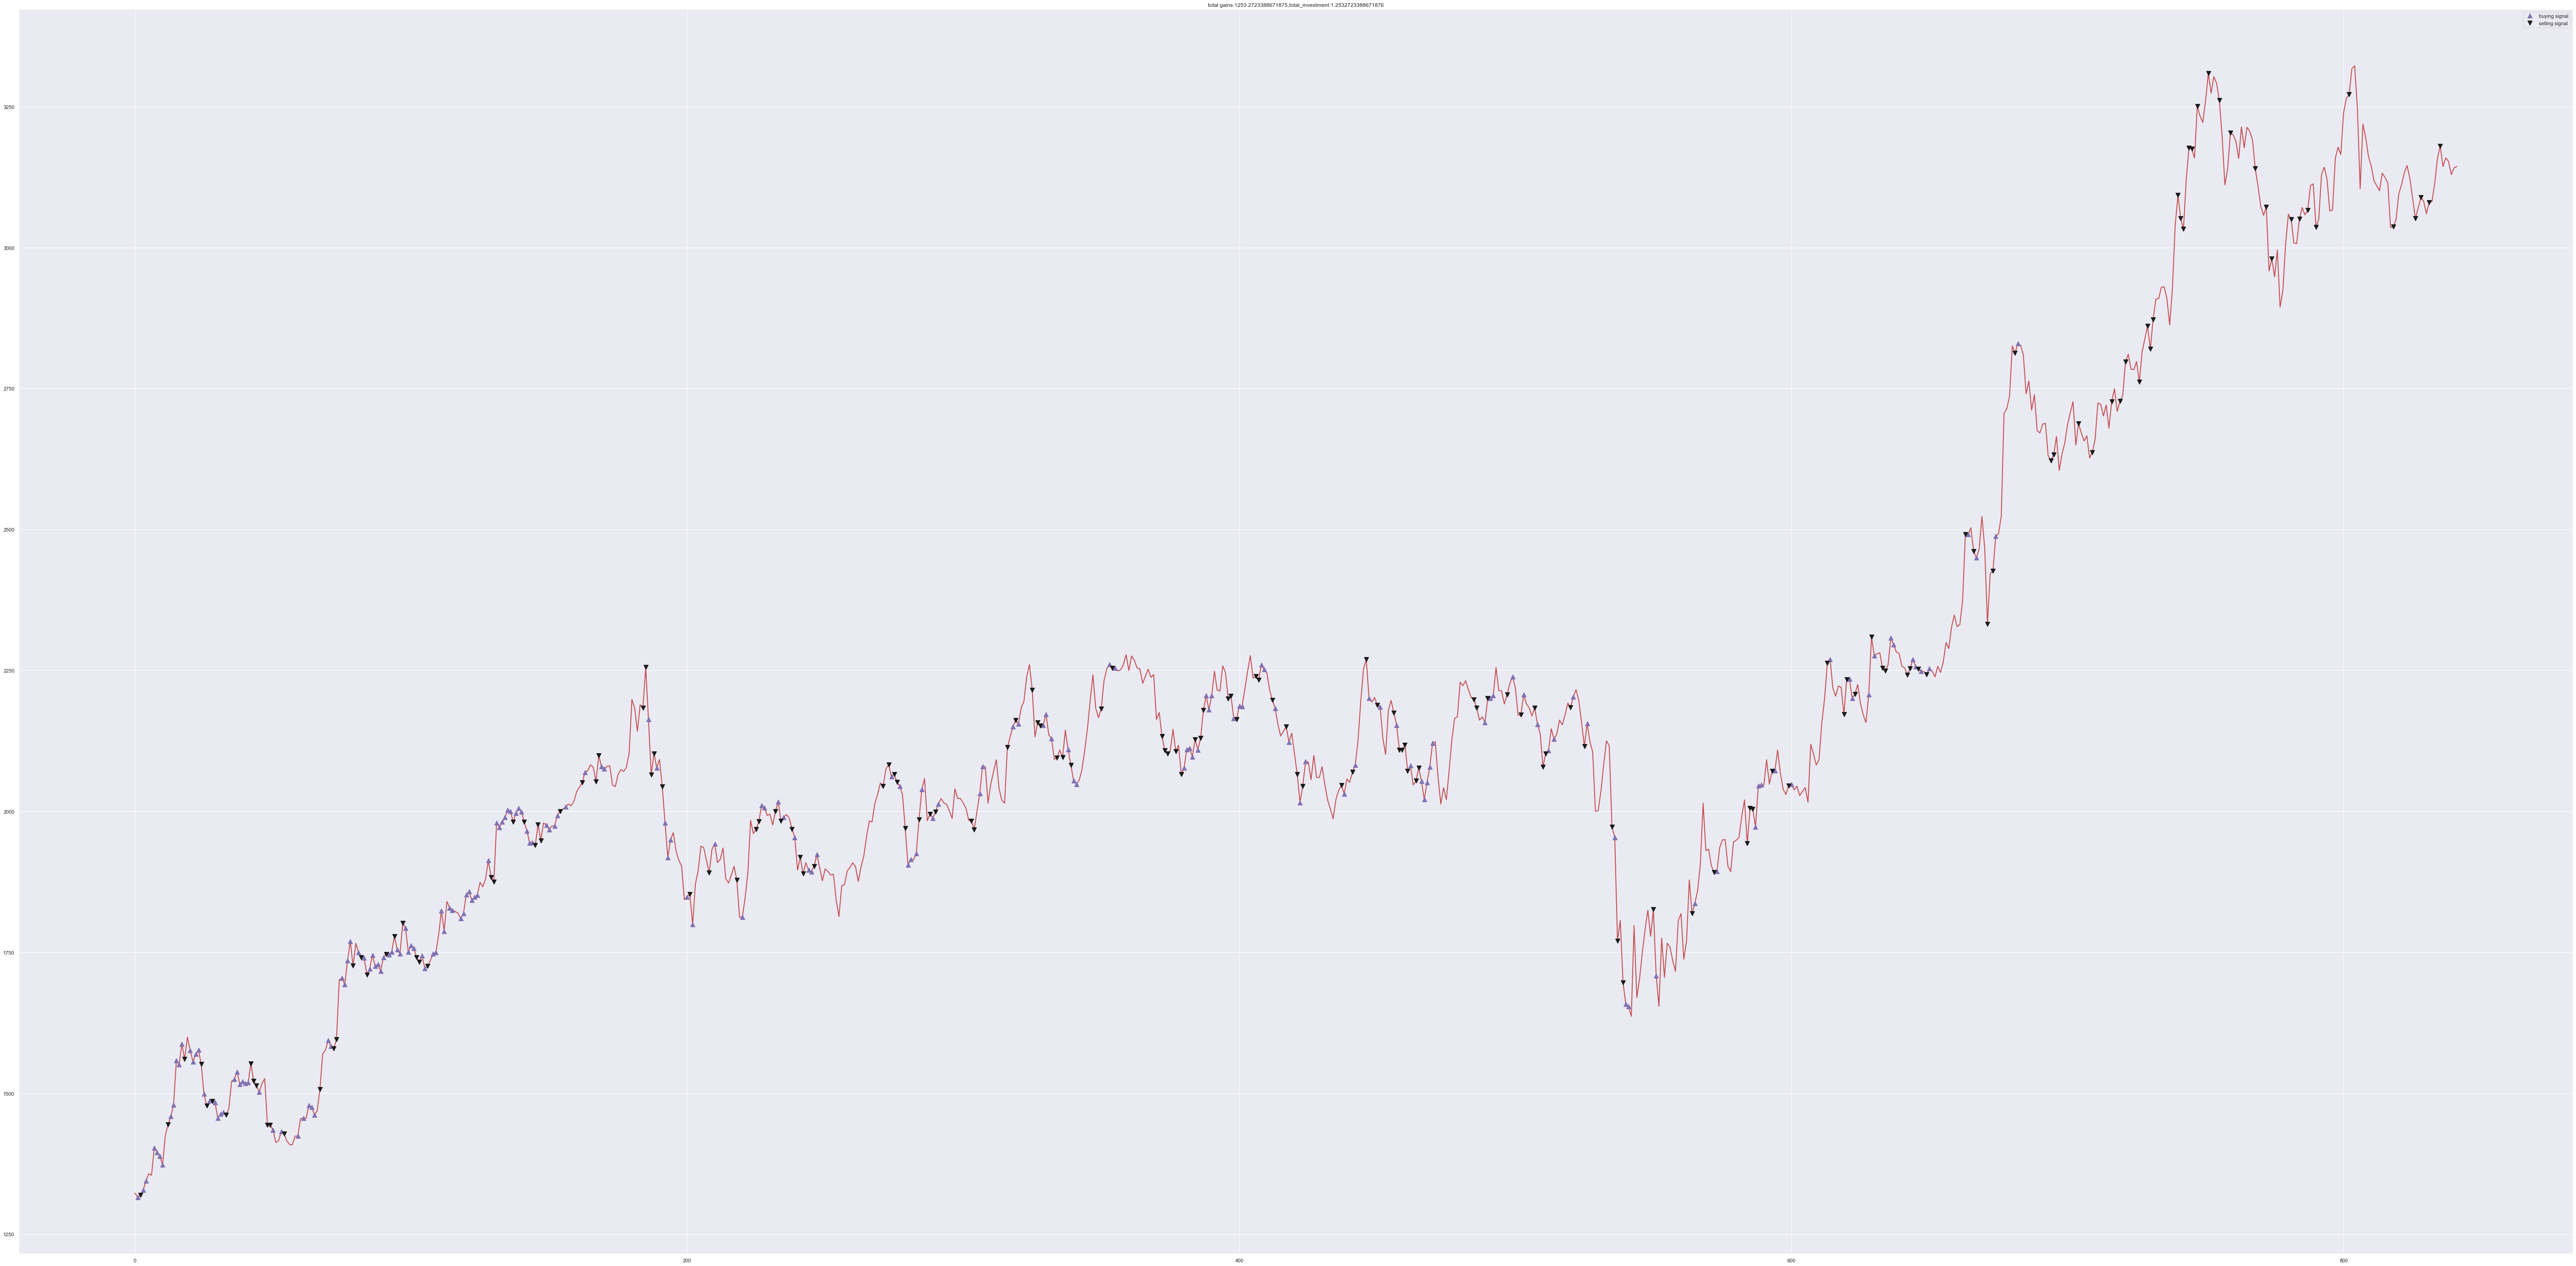

In [49]:
fig = plt.figure(figsize = (100,50))
plt.plot(close,color = 'r',lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title(f'total gains:{total_gains},total_investment:{invest}')
plt.legend()
plt.show()

In [41]:
# import tensorflow as tf
# x = tf.constant([[1., 1.], [2., 2.]])
# y = tf.reduce_mean(x)

# z = tf.reduce_mean(x, 0)
# k = tf.reduce_mean(x, 1)


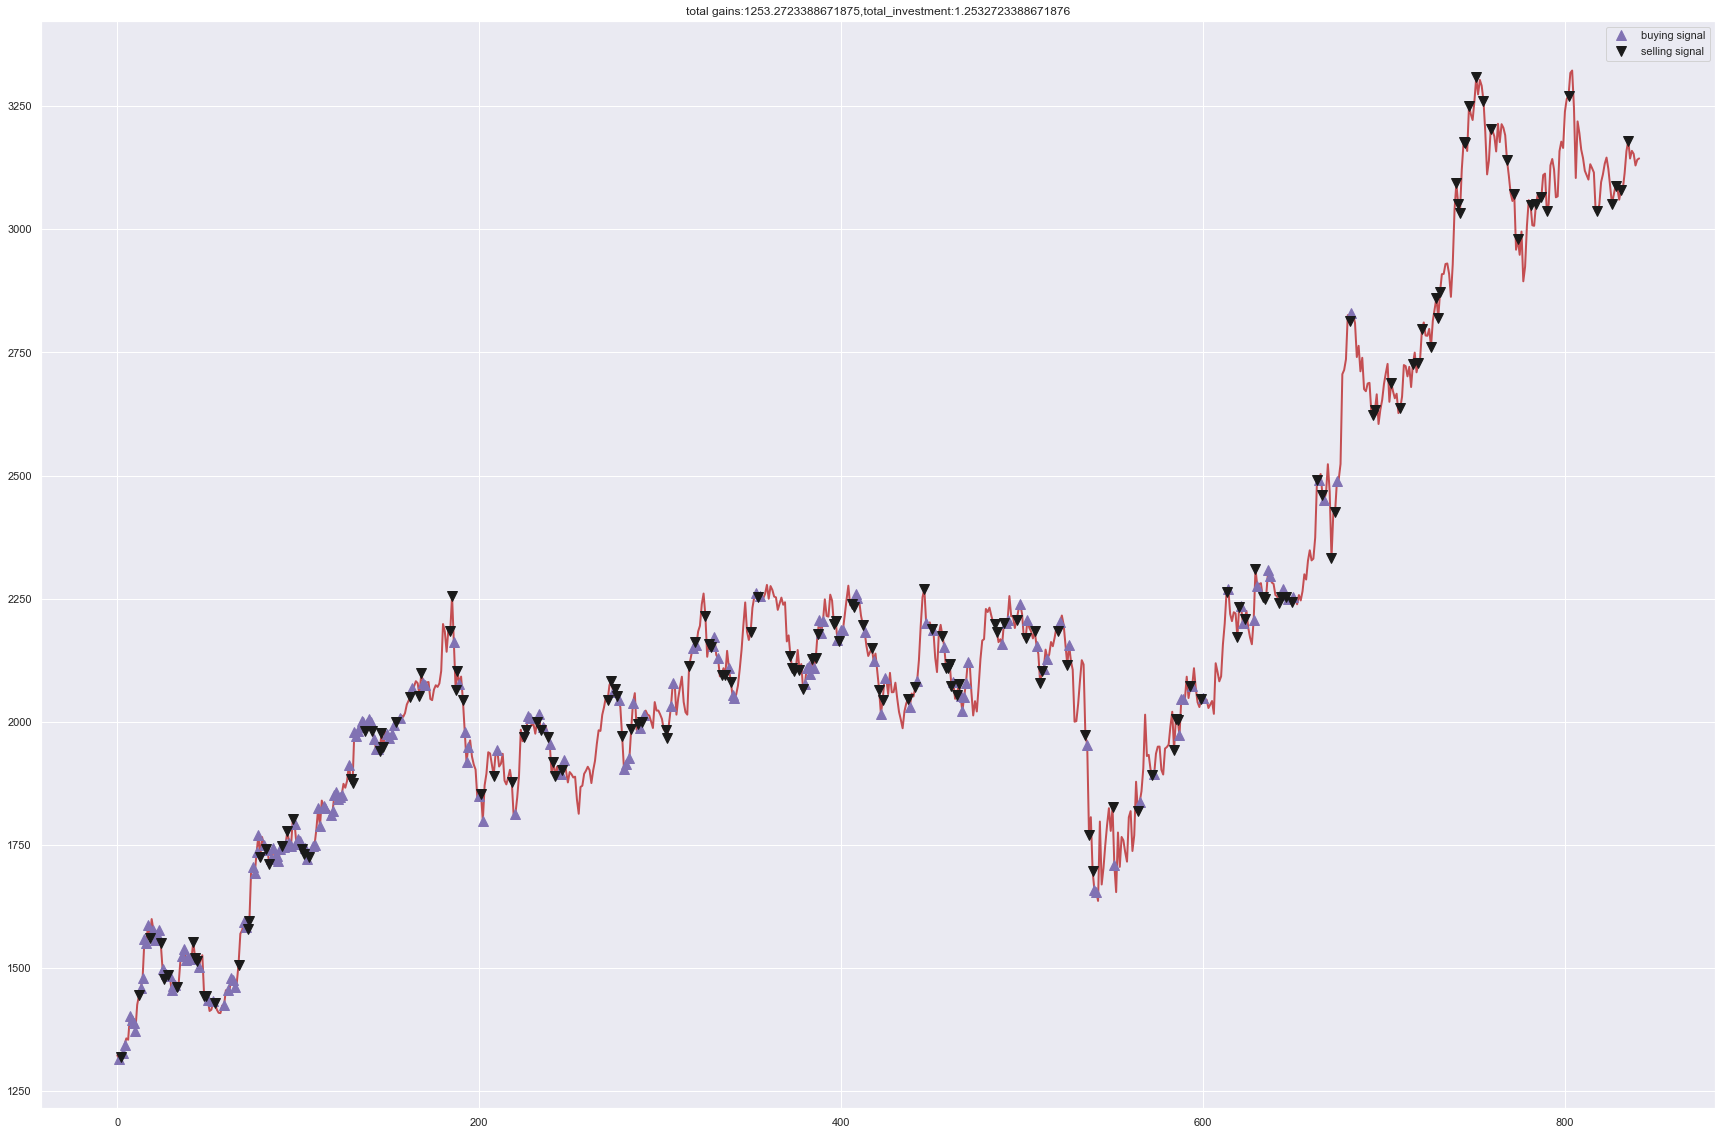

In [50]:
fig = plt.figure(figsize = (30,20))
plt.plot(close,color = 'r',lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title(f'total gains:{total_gains},total_investment:{invest}')
plt.legend()
plt.show()

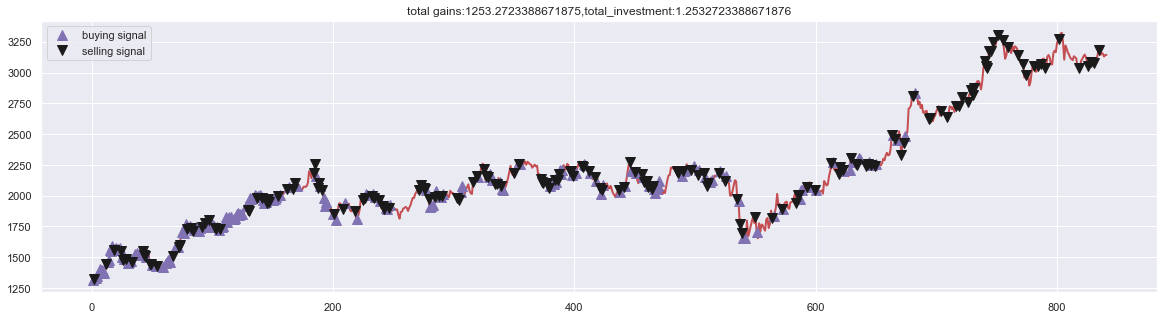

In [52]:
fig = plt.figure(figsize = (20,5))
plt.plot(close,color = 'r',lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title(f'total gains:{total_gains},total_investment:{invest}')
plt.legend()
plt.show()

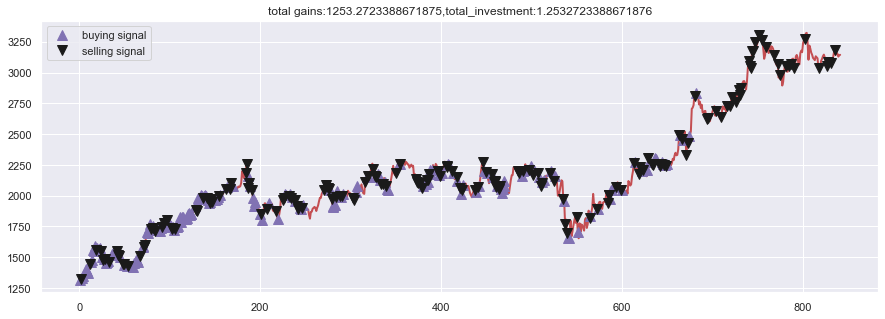

In [55]:
fig = plt.figure(figsize = (15,5))
plt.plot(close,color = 'r',lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title(f'total gains:{total_gains},total_investment:{invest}')
plt.legend()
plt.show()

In [57]:
! git add Updated_stock_reinforcement.ipynb
! git commit -m "22:38/05-06-2021"
! git push origin main

Nothing specified, nothing added.
hint: Maybe you wanted to say 'git add .'?
hint: Turn this message off by running
hint: "git config advice.addEmptyPathspec false"
